In [1]:
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import time as t

In [2]:
import pandas as pd
import sys
from env_pybullet_gen3 import env_pybullet_kin_gen3



In [3]:
#To improve the velocity, run it on the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device ', device)



#Create a experiment env
env = env_pybullet_kin_gen3(no_zeros = True)
env.robot.visual_inspection = False

#Initially parameters of the urdf



print('observation space:', env.observation_space) #states, There is only 1 state constant
env.update_parameters_to_modify(["mass","max_vel","kp","ki","damping","force_x_one","Ixx","Iyy","Izz"])
print('action space:', env.action_space) #parameters, number of parameters choose to tune, continuous
print('original action:', env.action_original()) #parameters, number of parameters choose to tune, continuous




Device  cpu
hola
../Simulation_Pybullet/models/urdf/JACO3_URDF_V11.urdf
Robot launched
hola
(7, 12)
(7, 17)
observation space: 1
mass okey
max_vel okey
kp okey
ki okey
damping okey
force_x_one okey
Ixx okey
Iyy okey
Izz okey
action space: 63
original action: [1.377353, 1.163667, 1.16366, 0.930287, 0.678106, 0.678106, 0.500657, 30, 30, 30, 30, 30, 30, 30, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 1, 1, 1, 1, 1, 1, 1, 0.00480078220558528, 0.008418724123621643, 0.007544516197001279, 0.0064096919604697605, 0.0016797846804208455, 0.0019375935324615593, 0.0007750385804833523, 0.004755191268457921, 0.0019202057294098781, 0.007486605057526543, 0.0013804130332615912, 0.0015062421641084327, 0.0008273237988932355, 0.0005849825981943527, 0.0022826303695446856, 0.00836116845951151, 0.0019205500000651847, 0.006517816917001926, 0.0008260694053789821, 0.0017630597813546379, 0.0009751695712112207]


In [4]:
#Cross Entrophy Method, to choose the weights

# In my case where only 1 action,and that it's apply the parameters do another step doesn't change anything due to the state doesn't vary
# For this reason max_t and gama doesn't make sense, so I set them to max_t = 1 and gamma to 0
def cem_no_net(n_iterations=600, max_t=1, gamma=0.0, print_every=100, pop_size=env.action_space, elite_frac=0.1, sigma=0.05,sigma_reduction_every_print = 0.65, per_one = True ):
    """PyTorch implementation of the cross-entropy method.
        
    Params
    ======
        n_iterations (int): maximum number of training iterations
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        pop_size (int): size of population at each iteration
        elite_frac (float): percentage of top performers to use in update
        sigma (float): standard deviation of additive noise
        per_one (boolean): to determine if the output is in per one or not
    """
    #Numbers of elements that you keep as the better ones
    n_elite=int(pop_size*elite_frac)
    
    #scores doble end queee , from iterations size * 0.1
    scores_deque = deque(maxlen=int(n_iterations*0.1))
    #intial scores empty
    scores = []
    #Select a seed to make the results the same every test, not depending on the seed
    np.random.seed(0)
    #Initial best weights, are from 0 to 1, it's good to be small the weights, but they should be different from 0.
    # small to avoid overfiting , different from 0 to update them
    
    if (per_one == True):
        best_weight = sigma*np.random.randn(env.action_space)
        original_action = np.array(env.action_original())
    else:
        best_weight = np.add(sigma*np.random.randn(env.action_space),env.action_original())

    #Each iteration, modify  + (from 0 to 1) the best weight randomly
    #Computes the reward with these weights
    #Sort the reward to get the best ones
    # Save the best weights
    # the Best weight it's the mean of the best one
    #compute the main reward of the main best rewards ones
    #this it's show to evalute how good its
    
    for i_iteration in range(1, n_iterations+1):
        
        #Generate new population weights, as a mutation of the best weight to test them
        weights_pop = [best_weight + (sigma*np.random.randn(env.action_space)) for i in range(pop_size)]
        
        #Compute the parameters and obtain the rewards for each of them
        
        if (per_one == True):
            rewards=[]
            for weights in weights_pop:
                #print(weights)
                action=np.add(np.multiply(weights,original_action),original_action)
                #t.sleep(10)
                rewards.append( env.step_tcp_euclidian(action) )
            rewards = np.array(rewards)
        else:
            rewards=[]
            for weights in weights_pop:
                rewards.append(env.step_tcp_euclidian(weights) )
            rewards = np.array(rewards)
        print("rewards" + str(i_iteration))
        print(rewards)
        #print("\n")
        
        #Sort the rewards to obtain the best ones
        elite_idxs = rewards.argsort()[-n_elite:]
        elite_weights = [weights_pop[i] for i in elite_idxs]
        
        #Set the best weight as the mean of the best ones 
       
        best_weight = np.array(elite_weights).mean(axis=0)
        
        #Get the reward with this new weight
        if (per_one == True):
            action = np.add(np.multiply(best_weight,original_action),original_action)
            reward = env.step_tcp_euclidian(action)
        else:
            reward = env.step_tcp_euclidian(best_weight)
        scores_deque.append(reward)
        scores.append(reward)
        
        #save the check point
        env.save_parameters("./Parameters_train_tcp_euc.xlsx")
        
        if i_iteration % print_every == 0:
            sigma = sigma * sigma_reduction_every_print
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))

        if np.mean(scores_deque)>=0.0:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-n_iterations*0.1, np.mean(scores_deque)))
            break
    return scores


rewards1
[-0.08417074 -0.07107277 -0.06915638 -0.08055044 -0.07677543 -0.06860293
 -0.07216666 -0.07798145 -0.08169168 -0.07451054 -0.06910352 -0.07594121
 -0.07854089 -0.07237318 -0.07476691 -0.07424793 -0.07750885 -0.07402216
 -0.07995872 -0.08769994 -0.07539526 -0.07208119 -0.08100393 -0.07553842
 -0.07134908 -0.07345199 -0.07811904 -0.07302978 -0.07826379 -0.07684906
 -0.06738833 -0.07400902 -0.08428832 -0.08629575 -0.08691825 -0.07345565
 -0.07341108 -0.07438385 -0.07366395 -0.07695207 -0.08406653 -0.06953294
 -0.07171209 -0.07090863 -0.0689856  -0.08214666 -0.07856275 -0.07068572
 -0.07865082 -0.07082266 -0.08211697 -0.08138335 -0.06930752 -0.06987176
 -0.07555065 -0.07008551 -0.07639174 -0.0775432  -0.07441154 -0.08017333
 -0.08866407 -0.07408937 -0.07031391]
rewards2
[-0.06722974 -0.07082337 -0.06779344 -0.06638746 -0.06440108 -0.06613591
 -0.06526357 -0.07064463 -0.06717411 -0.06841315 -0.07281336 -0.07078797
 -0.07304617 -0.07122557 -0.07308019 -0.06845001 -0.06574487 -0.0686

rewards12
[-0.04802289 -0.04974456 -0.04973752 -0.05053411 -0.05061144 -0.05211745
 -0.05504056 -0.04883175 -0.051383   -0.05056119 -0.04891627 -0.04976957
 -0.05029654 -0.05202628 -0.05010586 -0.05289137 -0.05072698 -0.05431118
 -0.04940266 -0.05001664 -0.05251399 -0.04777314 -0.04860037 -0.05342619
 -0.04945503 -0.048093   -0.0508017  -0.04964789 -0.04805507 -0.04720691
 -0.04971915 -0.04902903 -0.05111248 -0.04952557 -0.0488149  -0.04902236
 -0.04919552 -0.05310891 -0.052277   -0.05189085 -0.05655042 -0.04829808
 -0.05363833 -0.05052581 -0.05302781 -0.05119105 -0.04942492 -0.05073885
 -0.04863823 -0.05148579 -0.050969   -0.04944917 -0.05190728 -0.04738549
 -0.05044904 -0.04898307 -0.04740727 -0.05300666 -0.05535085 -0.04899356
 -0.04763252 -0.0487956  -0.05317736]
rewards13
[-0.04813746 -0.04816328 -0.05498218 -0.05016261 -0.04805699 -0.04932617
 -0.04831227 -0.05162161 -0.04962569 -0.0468615  -0.05356067 -0.04739947
 -0.05138554 -0.04923959 -0.04815275 -0.05377733 -0.04957405 -0.04

rewards23
[-0.03429608 -0.03210724 -0.03604869 -0.03640333 -0.03443077 -0.03566875
 -0.03400487 -0.03150436 -0.03611951 -0.03820766 -0.03836244 -0.03428567
 -0.0370205  -0.03349329 -0.03623352 -0.03602825 -0.03670219 -0.03458895
 -0.03329297 -0.03429228 -0.0362573  -0.03816242 -0.03388817 -0.0397244
 -0.03666847 -0.03717129 -0.03628933 -0.0387065  -0.03539738 -0.03354473
 -0.03716969 -0.03711258 -0.03629747 -0.03813742 -0.0321322  -0.03317101
 -0.03193828 -0.03019352 -0.03800892 -0.03315939 -0.04174932 -0.03721553
 -0.03894563 -0.03406577 -0.03878871 -0.03462567 -0.03620674 -0.03158332
 -0.03543394 -0.03137737 -0.03758115 -0.03508454 -0.03377554 -0.03784033
 -0.03267028 -0.03687262 -0.03778285 -0.03400819 -0.03910442 -0.03341893
 -0.03223576 -0.03478593 -0.03305499]
rewards24
[-0.03251196 -0.03566626 -0.0307567  -0.03716625 -0.03682989 -0.03543471
 -0.0327795  -0.03691803 -0.03272806 -0.03333283 -0.03294445 -0.03331199
 -0.03622742 -0.03680937 -0.03838124 -0.03951691 -0.03498817 -0.033

rewards34
[-0.02990805 -0.03143928 -0.03101027 -0.03314415 -0.03204492 -0.03175236
 -0.03363287 -0.03143584 -0.03294578 -0.03514708 -0.03064403 -0.03262424
 -0.03370772 -0.03262781 -0.03075389 -0.03154814 -0.04018845 -0.03244174
 -0.03113126 -0.03301234 -0.0350924  -0.03814655 -0.03487317 -0.03559602
 -0.0336874  -0.03465106 -0.03598294 -0.02917534 -0.02925202 -0.03241873
 -0.03419891 -0.02890522 -0.03305583 -0.03251136 -0.03021764 -0.0306407
 -0.03401178 -0.03696721 -0.0371388  -0.03424605 -0.03034209 -0.03083026
 -0.03161399 -0.03368781 -0.0356134  -0.03723335 -0.03064837 -0.02950972
 -0.03365314 -0.03240026 -0.0343302  -0.0308103  -0.03264732 -0.03206338
 -0.03268594 -0.03855741 -0.0322659  -0.03115974 -0.03612397 -0.02887522
 -0.03424849 -0.03152561 -0.03100759]
rewards35
[-0.03631333 -0.02971152 -0.0301007  -0.03238779 -0.03284663 -0.03143613
 -0.03403109 -0.03268899 -0.03056728 -0.03048032 -0.03305995 -0.03306329
 -0.03031895 -0.0324624  -0.0326122  -0.03536721 -0.03212922 -0.036

rewards45
[-0.032778   -0.03410063 -0.02999327 -0.03256278 -0.03303533 -0.030516
 -0.03267042 -0.03127927 -0.03085711 -0.03487145 -0.03064902 -0.02961498
 -0.03168675 -0.04164223 -0.03227004 -0.03222517 -0.03122102 -0.02920866
 -0.02968946 -0.03387954 -0.03186944 -0.03126909 -0.0332122  -0.0324094
 -0.03525187 -0.03319009 -0.03657125 -0.03631318 -0.03372139 -0.0325475
 -0.03155    -0.03152921 -0.03024348 -0.03027101 -0.0324523  -0.02913516
 -0.03355034 -0.03420219 -0.0318325  -0.02964781 -0.033048   -0.03416853
 -0.03413858 -0.03456647 -0.02814763 -0.03458646 -0.03401652 -0.03346458
 -0.03202626 -0.03219291 -0.0303259  -0.02930056 -0.03271066 -0.03613909
 -0.03146665 -0.03136116 -0.03409765 -0.03004376 -0.0327785  -0.03025087
 -0.03392652 -0.03533654 -0.03054404]
rewards46
[-0.04149575 -0.03270935 -0.03080259 -0.03239324 -0.03360735 -0.03094097
 -0.03208529 -0.03093932 -0.03056809 -0.02844935 -0.03118177 -0.03064351
 -0.0298202  -0.02916259 -0.03267161 -0.03222072 -0.03366301 -0.031185

rewards56
[-0.03133065 -0.03023103 -0.03049136 -0.03034804 -0.0318456  -0.03065796
 -0.03429113 -0.03258135 -0.0283385  -0.03076798 -0.03170239 -0.03224638
 -0.03175176 -0.03092576 -0.0311648  -0.03125594 -0.03066855 -0.0302318
 -0.03316094 -0.03086521 -0.02833239 -0.03437341 -0.02883962 -0.03261974
 -0.02954708 -0.03179618 -0.03258092 -0.02961894 -0.03286135 -0.03081752
 -0.03591182 -0.03127556 -0.03264699 -0.03617243 -0.03219317 -0.03347768
 -0.0297867  -0.03283619 -0.0340174  -0.03388054 -0.03138303 -0.03213497
 -0.03167461 -0.02828732 -0.03315671 -0.03193247 -0.03731691 -0.03041207
 -0.03214965 -0.02786794 -0.03218287 -0.02948307 -0.03248204 -0.03450294
 -0.03102215 -0.03749087 -0.03411248 -0.03270251 -0.0314764  -0.03223147
 -0.03022257 -0.03399849 -0.0367026 ]
rewards57
[-0.0343309  -0.03026537 -0.03171876 -0.03120538 -0.02915111 -0.0303061
 -0.02882224 -0.02847805 -0.0336866  -0.03520118 -0.03398359 -0.03063498
 -0.03031441 -0.03484672 -0.03183687 -0.03019267 -0.03317886 -0.0338

rewards67
[-0.03069778 -0.03027708 -0.03236153 -0.0298844  -0.03173942 -0.02663764
 -0.03187986 -0.03224194 -0.03137026 -0.03155812 -0.03244802 -0.03291067
 -0.03385689 -0.0319762  -0.03340758 -0.02940764 -0.03731392 -0.03053329
 -0.03232291 -0.03000337 -0.02910916 -0.03270416 -0.02905849 -0.03422918
 -0.03443    -0.03356253 -0.0347011  -0.027991   -0.0302437  -0.0297712
 -0.02832254 -0.03197403 -0.03169206 -0.03113532 -0.02874595 -0.0304729
 -0.03019199 -0.02842817 -0.03007403 -0.03092078 -0.03212982 -0.03231937
 -0.0307906  -0.03216802 -0.02978274 -0.0356034  -0.02819668 -0.02847797
 -0.03480873 -0.032053   -0.03286213 -0.03300715 -0.03393374 -0.03179273
 -0.03105513 -0.02842664 -0.0313218  -0.03252433 -0.02824427 -0.03143192
 -0.03428612 -0.03090256 -0.02921993]
rewards68
[-0.02782401 -0.0293916  -0.03360911 -0.03220253 -0.03018911 -0.02945381
 -0.03257983 -0.03724553 -0.02944467 -0.03136172 -0.02869974 -0.03827579
 -0.03108302 -0.02852796 -0.0323898  -0.03388241 -0.03145311 -0.0297

rewards78
[-0.03798917 -0.02673421 -0.03027564 -0.02684682 -0.03169106 -0.02986659
 -0.0327918  -0.03048605 -0.02960694 -0.03143276 -0.02925902 -0.03195172
 -0.030494   -0.02961717 -0.02595535 -0.02874845 -0.03021304 -0.02913128
 -0.03053498 -0.0301312  -0.02933314 -0.02692467 -0.03020011 -0.02806175
 -0.03271488 -0.02738768 -0.03477308 -0.03124318 -0.02982367 -0.03109247
 -0.02999923 -0.03066448 -0.02942955 -0.02693007 -0.02943045 -0.03145679
 -0.02772633 -0.02925072 -0.02910731 -0.03167976 -0.0280902  -0.033652
 -0.0281873  -0.03097085 -0.03329724 -0.03218219 -0.03586434 -0.02823839
 -0.02955507 -0.02809024 -0.03235971 -0.02984474 -0.03284439 -0.03092826
 -0.02935255 -0.03092171 -0.0285527  -0.02828309 -0.02975366 -0.03235465
 -0.03121479 -0.02963084 -0.02904476]
rewards79
[-0.02835868 -0.02833887 -0.02801257 -0.03338799 -0.02823275 -0.02961599
 -0.0282588  -0.02936256 -0.02868943 -0.03103782 -0.03115759 -0.02991006
 -0.03039442 -0.02867319 -0.0289681  -0.03018502 -0.03648151 -0.0290

rewards89
[-0.02707853 -0.03296704 -0.02858974 -0.02848854 -0.03092917 -0.03096758
 -0.02865115 -0.03163445 -0.0360102  -0.03016549 -0.02898678 -0.02908989
 -0.03839919 -0.03349038 -0.03042275 -0.02708459 -0.0322178  -0.02937516
 -0.03109579 -0.02991105 -0.03030159 -0.02841401 -0.02625252 -0.02716284
 -0.02897889 -0.02890049 -0.02836845 -0.02881426 -0.03313137 -0.0295618
 -0.03152481 -0.03067169 -0.0266785  -0.03147697 -0.02903003 -0.03316002
 -0.03258362 -0.02712327 -0.02998021 -0.02858001 -0.02759477 -0.02843002
 -0.02977971 -0.02791152 -0.0298973  -0.02893908 -0.02900692 -0.03485255
 -0.02868768 -0.03821196 -0.03044931 -0.02983613 -0.0334653  -0.03001109
 -0.03224933 -0.03188335 -0.02951645 -0.02797245 -0.02973875 -0.02966913
 -0.03015887 -0.03230809 -0.02805863]
rewards90
[-0.03595777 -0.02860987 -0.02715945 -0.02596864 -0.02775422 -0.02794351
 -0.02924563 -0.03455833 -0.03049703 -0.02904892 -0.0298163  -0.02798703
 -0.0282643  -0.02828758 -0.02881297 -0.03063285 -0.02645846 -0.025

rewards100
[-0.03033528 -0.02869283 -0.02867577 -0.03134429 -0.0319194  -0.0310764
 -0.02893307 -0.02890946 -0.02957175 -0.03179732 -0.02804086 -0.03017368
 -0.03168744 -0.03053041 -0.02944683 -0.02650076 -0.03014372 -0.03113575
 -0.02897656 -0.02836096 -0.02626336 -0.02722497 -0.02909445 -0.02604873
 -0.03506932 -0.0319945  -0.02719323 -0.03449991 -0.03186    -0.02932364
 -0.02952521 -0.03466809 -0.03038149 -0.03227976 -0.02950431 -0.03388767
 -0.02961597 -0.02891417 -0.02974229 -0.02887215 -0.02796839 -0.03263221
 -0.034297   -0.03359985 -0.03069922 -0.02971178 -0.02822772 -0.02844572
 -0.02657001 -0.0292586  -0.02725008 -0.02923614 -0.02697003 -0.02656144
 -0.03189232 -0.03008701 -0.03004432 -0.02922484 -0.02859624 -0.02864644
 -0.028811   -0.02791267 -0.0310668 ]
Episode 100	Average Score: -0.03
rewards101
[-0.02814889 -0.03542397 -0.0274754  -0.02521894 -0.02730206 -0.02644293
 -0.02795642 -0.02522684 -0.02645306 -0.02682368 -0.02889047 -0.0252572
 -0.02627019 -0.02794582 -0.02539

rewards111
[-0.02556159 -0.03239471 -0.02680818 -0.02889057 -0.02613903 -0.02598054
 -0.02910566 -0.03163118 -0.02762631 -0.02867534 -0.02753811 -0.0271272
 -0.02652019 -0.02718506 -0.02786608 -0.02850988 -0.02819209 -0.028319
 -0.02815692 -0.02688231 -0.02770891 -0.02861638 -0.02798249 -0.02725845
 -0.02671784 -0.02713356 -0.02800907 -0.03111267 -0.02874804 -0.02816262
 -0.02566307 -0.02726423 -0.02692391 -0.0285286  -0.02628185 -0.02814073
 -0.02866912 -0.02488276 -0.02669697 -0.02784757 -0.02848281 -0.02632021
 -0.02584804 -0.0297081  -0.02790701 -0.02718039 -0.02787278 -0.02538387
 -0.02751952 -0.02915025 -0.0252227  -0.02874913 -0.02896589 -0.02681595
 -0.02556238 -0.02794677 -0.02657798 -0.02545004 -0.02719595 -0.02582142
 -0.02826808 -0.02700566 -0.02873588]
rewards112
[-0.02751812 -0.02859595 -0.02649802 -0.02678297 -0.02508084 -0.02994846
 -0.02864402 -0.02684652 -0.02636895 -0.02875019 -0.02631985 -0.02531075
 -0.02764732 -0.02722352 -0.02842896 -0.0295327  -0.02499791 -0.029

rewards122
[-0.02434429 -0.02755782 -0.02875305 -0.02847831 -0.02869781 -0.02670094
 -0.0278536  -0.0298349  -0.02750389 -0.02699824 -0.02879061 -0.02751566
 -0.02876501 -0.02824289 -0.02545088 -0.02829635 -0.02792651 -0.02714896
 -0.02660314 -0.02689542 -0.02503587 -0.02662617 -0.02747695 -0.02742399
 -0.02712686 -0.02673629 -0.02531033 -0.02739703 -0.02824892 -0.02664219
 -0.02507216 -0.02505468 -0.02803557 -0.02663565 -0.02845768 -0.02615417
 -0.02535949 -0.02658334 -0.02788724 -0.02788745 -0.0262339  -0.03101723
 -0.02482381 -0.03252438 -0.02721456 -0.02727374 -0.02728284 -0.02549569
 -0.02733107 -0.02792267 -0.02670422 -0.02538347 -0.02690172 -0.02878998
 -0.02640762 -0.02506805 -0.02796385 -0.02689397 -0.02781165 -0.02906758
 -0.02512555 -0.02933439 -0.02889816]
rewards123
[-0.02899507 -0.03067076 -0.02478922 -0.02878026 -0.02563364 -0.02731585
 -0.02840891 -0.02739395 -0.02677344 -0.02576466 -0.02668684 -0.028222
 -0.02623191 -0.02597288 -0.0277398  -0.02697478 -0.02568636 -0.02

rewards133
[-0.02791435 -0.02879534 -0.02854791 -0.0257856  -0.02604349 -0.02626806
 -0.02908182 -0.02808721 -0.02845589 -0.02676548 -0.02732492 -0.02665244
 -0.02605517 -0.02487075 -0.03035487 -0.02871339 -0.02659843 -0.0266587
 -0.02898668 -0.02850699 -0.03014272 -0.02930732 -0.02848473 -0.02788247
 -0.02833156 -0.02515028 -0.02546806 -0.02773066 -0.03033001 -0.0246873
 -0.02948579 -0.02638967 -0.02558171 -0.02770961 -0.02862719 -0.02932281
 -0.02948722 -0.027452   -0.02503281 -0.02650217 -0.02538604 -0.02498407
 -0.02578205 -0.02552114 -0.0248372  -0.02644117 -0.02647665 -0.02869518
 -0.02505442 -0.02610336 -0.02641473 -0.02642496 -0.02873093 -0.02578711
 -0.02697652 -0.02726445 -0.02704525 -0.02588049 -0.02732753 -0.02851698
 -0.02712308 -0.02596428 -0.02799464]
rewards134
[-0.02610797 -0.02713432 -0.02454904 -0.02563621 -0.02787563 -0.02928564
 -0.02846565 -0.02705158 -0.0269962  -0.02551804 -0.02749584 -0.02711132
 -0.02637434 -0.02482403 -0.0287274  -0.0298317  -0.02648848 -0.02

rewards144
[-0.0249808  -0.02732684 -0.02890913 -0.02747192 -0.02945253 -0.02732714
 -0.02488074 -0.0248878  -0.02713821 -0.02686046 -0.0257246  -0.02618869
 -0.02665614 -0.02589585 -0.0254148  -0.02847535 -0.02761193 -0.02657973
 -0.02568987 -0.02816123 -0.02591562 -0.0248091  -0.02818264 -0.02787103
 -0.02745169 -0.02763105 -0.02892929 -0.02726628 -0.02725926 -0.02461446
 -0.02616268 -0.02782023 -0.02479356 -0.02682973 -0.0333338  -0.02527058
 -0.02653699 -0.02471183 -0.02722391 -0.02677082 -0.0262092  -0.02675155
 -0.02618291 -0.02554168 -0.02870824 -0.02446249 -0.0252059  -0.02858061
 -0.02649491 -0.02557252 -0.02866548 -0.02851791 -0.02441045 -0.02435953
 -0.02649356 -0.02654651 -0.02740095 -0.02781718 -0.02675491 -0.02782793
 -0.02819732 -0.02470088 -0.02849202]
rewards145
[-0.02731656 -0.02825998 -0.0289132  -0.02407433 -0.02634552 -0.02777371
 -0.02778673 -0.02928211 -0.02526768 -0.02726054 -0.02517819 -0.02608127
 -0.02651084 -0.02784431 -0.02697231 -0.02704189 -0.02492711 -0.

rewards155
[-0.02667611 -0.0258872  -0.02679654 -0.02558296 -0.02715572 -0.02686824
 -0.02486305 -0.02521436 -0.02518251 -0.0296857  -0.02880869 -0.02522683
 -0.02665516 -0.02578004 -0.0242802  -0.02556632 -0.02489643 -0.02823256
 -0.02597515 -0.02909895 -0.02591242 -0.02706245 -0.02421967 -0.02739708
 -0.02576936 -0.02815801 -0.02614776 -0.02620695 -0.03023999 -0.02505699
 -0.02743407 -0.0255315  -0.02622961 -0.02528337 -0.02440741 -0.02509168
 -0.03275458 -0.02409531 -0.02646044 -0.02432682 -0.02633182 -0.02610168
 -0.02724044 -0.026239   -0.02855941 -0.02730063 -0.02418301 -0.02614218
 -0.02620035 -0.02967069 -0.02902565 -0.02835794 -0.0272517  -0.02676813
 -0.02926496 -0.0283854  -0.0276637  -0.02754454 -0.02599036 -0.02492942
 -0.02603513 -0.02616245 -0.02648109]
rewards156
[-0.02482523 -0.02695325 -0.02552459 -0.02543551 -0.02744658 -0.02703633
 -0.02912868 -0.02664378 -0.02922272 -0.0243472  -0.02721547 -0.02780404
 -0.02773868 -0.02840613 -0.02712754 -0.02615424 -0.02733493 -0.

rewards166
[-0.02411847 -0.02689711 -0.02669793 -0.02494162 -0.02638918 -0.02721259
 -0.02669245 -0.02385796 -0.02866607 -0.02510493 -0.03077419 -0.02482793
 -0.02671517 -0.02676304 -0.02421014 -0.02470403 -0.02662305 -0.02671399
 -0.02720752 -0.02476709 -0.02873636 -0.02799823 -0.02669998 -0.0280648
 -0.02455917 -0.02835021 -0.02513136 -0.02648733 -0.02640895 -0.02470842
 -0.02507032 -0.02984103 -0.02737954 -0.02880388 -0.02953521 -0.02612453
 -0.02496462 -0.02398419 -0.02606831 -0.02536186 -0.02738105 -0.02753182
 -0.02550115 -0.02699516 -0.0272753  -0.02421791 -0.02841502 -0.0268138
 -0.02674407 -0.02462992 -0.02639672 -0.02686967 -0.02702713 -0.02659542
 -0.02702543 -0.02630116 -0.02632186 -0.02582335 -0.02670611 -0.02598545
 -0.02632675 -0.02479058 -0.02767247]
rewards167
[-0.02645192 -0.02736515 -0.02638699 -0.0253005  -0.0268793  -0.02637721
 -0.02684318 -0.02716915 -0.02471039 -0.02695821 -0.02613996 -0.0270029
 -0.02627231 -0.02446087 -0.0290172  -0.02575035 -0.02396698 -0.025

rewards177
[-0.02899499 -0.02558156 -0.02486055 -0.03065344 -0.02882596 -0.02371616
 -0.02686765 -0.02752112 -0.0243998  -0.02490273 -0.02778974 -0.02575361
 -0.0255273  -0.02509483 -0.02636002 -0.03004481 -0.02577785 -0.02740445
 -0.02768778 -0.02617593 -0.02775061 -0.02683376 -0.02456303 -0.02601555
 -0.0280527  -0.02383931 -0.02783231 -0.02727661 -0.02481941 -0.02919047
 -0.02780488 -0.02675219 -0.02446278 -0.02351513 -0.02777588 -0.02669912
 -0.02762069 -0.02688957 -0.02472387 -0.02456229 -0.02426868 -0.03138778
 -0.0284125  -0.02757325 -0.02972016 -0.02783791 -0.02457684 -0.02568627
 -0.02963167 -0.02385153 -0.03000096 -0.02788149 -0.02728788 -0.02649184
 -0.0278583  -0.02612526 -0.02706652 -0.02587985 -0.02580767 -0.0285147
 -0.02883694 -0.02674641 -0.02729154]
rewards178
[-0.02632555 -0.02667939 -0.02666065 -0.02621648 -0.03050227 -0.02416008
 -0.02481911 -0.03373939 -0.02479806 -0.02436407 -0.02458829 -0.02709584
 -0.02484264 -0.02561986 -0.02533634 -0.02811844 -0.02514127 -0.0

rewards188
[-0.02394229 -0.02510414 -0.02523086 -0.02681811 -0.02428859 -0.02665897
 -0.02593825 -0.02667906 -0.02570529 -0.02610685 -0.02714086 -0.02548767
 -0.02537288 -0.02398569 -0.02671004 -0.02536211 -0.0246681  -0.02640012
 -0.02610574 -0.02561952 -0.02698268 -0.02709477 -0.02382746 -0.02424707
 -0.02613575 -0.02602234 -0.02443057 -0.02631074 -0.02437746 -0.02661958
 -0.02571327 -0.0274532  -0.02577526 -0.02636117 -0.0244551  -0.02341993
 -0.02405194 -0.02471394 -0.02334805 -0.02501983 -0.02394472 -0.02384424
 -0.02375268 -0.02722561 -0.02382841 -0.02383576 -0.02452314 -0.02427786
 -0.02675085 -0.02539724 -0.02384777 -0.02566107 -0.02628092 -0.02407581
 -0.02669334 -0.02558716 -0.02631076 -0.02412434 -0.02381687 -0.02825621
 -0.02662755 -0.02526835 -0.02500599]
rewards189
[-0.02638025 -0.02870561 -0.02566146 -0.02749868 -0.02756971 -0.02695662
 -0.0268496  -0.02658114 -0.02612911 -0.02552523 -0.02555546 -0.02431387
 -0.02675915 -0.02749379 -0.02496165 -0.02559058 -0.02418443 -0.

rewards199
[-0.02717727 -0.02415161 -0.02688879 -0.02862519 -0.02796355 -0.02835191
 -0.02425514 -0.02687209 -0.0269401  -0.0248582  -0.02614587 -0.027614
 -0.02876849 -0.02327663 -0.02439502 -0.02628312 -0.02689615 -0.02495201
 -0.0241086  -0.02629122 -0.02638051 -0.0252464  -0.02752386 -0.02505003
 -0.0251355  -0.03614359 -0.02577681 -0.02706071 -0.0268131  -0.02409878
 -0.02417292 -0.02727718 -0.02844295 -0.02673912 -0.02731173 -0.02545366
 -0.02637075 -0.02459673 -0.02597717 -0.02345714 -0.02719526 -0.02561318
 -0.02646919 -0.02640884 -0.02482857 -0.02634285 -0.02344765 -0.02402934
 -0.0264404  -0.02656221 -0.03260502 -0.02339578 -0.02885439 -0.02658755
 -0.02708125 -0.02940009 -0.02591276 -0.02412799 -0.02372405 -0.02421806
 -0.02766292 -0.02557942 -0.02594748]
rewards200
[-0.02821959 -0.02621444 -0.02677417 -0.02664762 -0.02596816 -0.02732136
 -0.02635146 -0.02553029 -0.02728937 -0.02440678 -0.0293876  -0.02425265
 -0.02478634 -0.02550593 -0.02590821 -0.02519896 -0.02389633 -0.02

rewards210
[-0.02580538 -0.0252363  -0.02308044 -0.02407149 -0.02399482 -0.02570177
 -0.02322448 -0.02374749 -0.02305911 -0.0238772  -0.02567646 -0.02323259
 -0.02607215 -0.02533552 -0.02336669 -0.0229079  -0.02374336 -0.0255734
 -0.02540553 -0.02414938 -0.02640469 -0.02581503 -0.02310376 -0.02634565
 -0.02415444 -0.02347867 -0.02350536 -0.02579381 -0.0234617  -0.02565167
 -0.02663452 -0.02548776 -0.02353228 -0.02483834 -0.02504511 -0.02424204
 -0.02433398 -0.0237782  -0.02324208 -0.0257883  -0.02312525 -0.02598631
 -0.02631906 -0.02344575 -0.02400115 -0.02473919 -0.02427027 -0.02424359
 -0.02562953 -0.02354    -0.02367163 -0.02652607 -0.0257783  -0.02498979
 -0.02637652 -0.02331359 -0.02505776 -0.02707468 -0.02395748 -0.02454605
 -0.02557927 -0.02570167 -0.0250947 ]
rewards211
[-0.02375362 -0.02532559 -0.02377815 -0.02506855 -0.02344676 -0.02571278
 -0.0233654  -0.02516561 -0.02618013 -0.02418588 -0.02404083 -0.02374556
 -0.02363389 -0.02500302 -0.02562596 -0.02345216 -0.02381779 -0.0

rewards221
[-0.02303731 -0.02424538 -0.02300862 -0.02358616 -0.02561779 -0.02314635
 -0.02325417 -0.02421687 -0.02539064 -0.0236211  -0.02479231 -0.02517519
 -0.02454045 -0.02539183 -0.02324875 -0.02586975 -0.0255149  -0.02406829
 -0.02339661 -0.02520172 -0.0247105  -0.02391926 -0.02330932 -0.02661672
 -0.02272576 -0.0227936  -0.02679453 -0.02497262 -0.02294878 -0.02417517
 -0.02549791 -0.0228746  -0.02385041 -0.02555989 -0.02545512 -0.02610772
 -0.02326665 -0.02371448 -0.024054   -0.02339775 -0.02703239 -0.02394395
 -0.0253138  -0.02322626 -0.02548888 -0.02504202 -0.02314821 -0.02288038
 -0.0231132  -0.02596974 -0.02292527 -0.0231078  -0.02335046 -0.02483817
 -0.02584585 -0.02313295 -0.02285445 -0.02424474 -0.02321125 -0.02702848
 -0.02357615 -0.02330972 -0.02542355]
rewards222
[-0.02492136 -0.02277233 -0.02336112 -0.02310434 -0.02531067 -0.02577804
 -0.02353892 -0.02317757 -0.02358909 -0.02313544 -0.02306596 -0.02352195
 -0.0230011  -0.02326299 -0.02567748 -0.02571227 -0.02337195 -0.

rewards232
[-0.02479178 -0.0256114  -0.02330488 -0.02443101 -0.02352435 -0.0248955
 -0.02297804 -0.02308856 -0.02441675 -0.02293771 -0.02459943 -0.02489911
 -0.0230557  -0.02332099 -0.02348707 -0.02436559 -0.02756596 -0.0229558
 -0.02548502 -0.02576902 -0.02324431 -0.02328792 -0.022812   -0.02446688
 -0.02418917 -0.02497551 -0.02411654 -0.02586088 -0.02304891 -0.02327718
 -0.02282018 -0.0237551  -0.022981   -0.02351409 -0.02335682 -0.02284485
 -0.02327258 -0.02423396 -0.02363696 -0.02372321 -0.02314759 -0.02303156
 -0.02378276 -0.02407893 -0.02388152 -0.02364366 -0.02288635 -0.02293817
 -0.02495185 -0.02435238 -0.02280757 -0.02292865 -0.02488676 -0.02291831
 -0.02351654 -0.02325314 -0.02598043 -0.02325939 -0.02457418 -0.022774
 -0.0230544  -0.02475578 -0.02381957]
rewards233
[-0.02354111 -0.02362363 -0.02483038 -0.02335681 -0.02429926 -0.02294532
 -0.02439908 -0.02302741 -0.02501041 -0.02663126 -0.02423275 -0.02376508
 -0.02381609 -0.02272883 -0.0237854  -0.02495899 -0.0231227  -0.0230

rewards243
[-0.02332926 -0.02055706 -0.02306391 -0.02060973 -0.0248504  -0.02052382
 -0.032682   -0.02115798 -0.02149563 -0.02306819 -0.0238224  -0.0209027
 -0.02353713 -0.0209648  -0.02577923 -0.02319925 -0.02086573 -0.02197019
 -0.02257028 -0.02274782 -0.0223277  -0.0211081  -0.02125491 -0.02346637
 -0.02279814 -0.0207742  -0.02372393 -0.02395605 -0.02428748 -0.02063753
 -0.02091359 -0.02462044 -0.02062585 -0.02081914 -0.03280964 -0.02613032
 -0.02183592 -0.02416573 -0.02101308 -0.02285897 -0.02048291 -0.02225831
 -0.02062445 -0.02461685 -0.02495478 -0.02131098 -0.03165209 -0.02315173
 -0.02282732 -0.02131629 -0.02178588 -0.02295134 -0.02325122 -0.02291878
 -0.02159568 -0.02307075 -0.02375855 -0.02552853 -0.02281142 -0.0211646
 -0.02285149 -0.02108991 -0.02318014]
rewards244
[-0.02296737 -0.02076666 -0.02082194 -0.02509822 -0.02392112 -0.02282581
 -0.02095718 -0.02182837 -0.02142974 -0.02356124 -0.02088718 -0.02437114
 -0.02352879 -0.02632505 -0.02363895 -0.02365798 -0.02350229 -0.02

rewards254
[-0.02223012 -0.02537574 -0.02239168 -0.02283238 -0.02111448 -0.02264226
 -0.02080803 -0.02204135 -0.02086312 -0.0226934  -0.02193814 -0.0202423
 -0.02570079 -0.02342918 -0.02323207 -0.02042546 -0.02055246 -0.0202055
 -0.02115889 -0.02066306 -0.02353392 -0.02273329 -0.02308169 -0.02048501
 -0.02111325 -0.02041726 -0.02061001 -0.02131759 -0.02222579 -0.02223908
 -0.02042566 -0.02024097 -0.02097317 -0.02284995 -0.02577566 -0.02013227
 -0.02080416 -0.0223171  -0.0205325  -0.02056729 -0.02289691 -0.02288082
 -0.02277411 -0.02100891 -0.02095631 -0.02092805 -0.02370212 -0.02235028
 -0.02034236 -0.02094588 -0.02348321 -0.02489922 -0.02548559 -0.02309796
 -0.02279218 -0.02340813 -0.0237012  -0.02037703 -0.02119322 -0.02073803
 -0.02079838 -0.02313646 -0.02168592]
rewards255
[-0.0236373  -0.02062769 -0.02016441 -0.02049128 -0.020924   -0.02035353
 -0.02037348 -0.02039407 -0.02136107 -0.03311639 -0.0210612  -0.0210581
 -0.02306584 -0.02116043 -0.022358   -0.02266181 -0.02124441 -0.022

rewards265
[-0.02026934 -0.02440483 -0.02259113 -0.02560481 -0.02544964 -0.02167366
 -0.0206854  -0.02086018 -0.02701379 -0.02073598 -0.02418399 -0.02310681
 -0.02127401 -0.020521   -0.02168991 -0.0228749  -0.02871622 -0.01991427
 -0.0229401  -0.02018984 -0.02251187 -0.02382976 -0.02876931 -0.02080923
 -0.02834013 -0.02005977 -0.02029401 -0.0270983  -0.02324705 -0.01999187
 -0.02080847 -0.02057345 -0.02257062 -0.02036854 -0.02076851 -0.03110815
 -0.02104121 -0.02175918 -0.02027225 -0.02147138 -0.02500794 -0.02687166
 -0.0225532  -0.02283907 -0.0294402  -0.02565334 -0.02169656 -0.02025538
 -0.02479137 -0.02027126 -0.02126265 -0.02491001 -0.02315807 -0.0224461
 -0.02104157 -0.0200992  -0.02365809 -0.02220207 -0.02136851 -0.02088208
 -0.02248598 -0.02025625 -0.02269223]
rewards266
[-0.01981491 -0.02657391 -0.02066939 -0.02225394 -0.02140057 -0.02161836
 -0.02333096 -0.02072158 -0.02766803 -0.02168044 -0.03134735 -0.02434508
 -0.02292774 -0.02046874 -0.02289111 -0.02081461 -0.02523008 -0.0

rewards276
[-0.0208267  -0.02236871 -0.0255847  -0.02128474 -0.02265545 -0.02311226
 -0.02156214 -0.02035877 -0.02029461 -0.02239913 -0.02061317 -0.02138105
 -0.02248153 -0.02059486 -0.02483254 -0.02148055 -0.02171271 -0.02194741
 -0.02053494 -0.0222345  -0.03090539 -0.02069886 -0.02080193 -0.02030204
 -0.02139089 -0.0236651  -0.02069014 -0.02054121 -0.02027688 -0.02033005
 -0.02031056 -0.02018272 -0.02134897 -0.02283872 -0.02112764 -0.02280201
 -0.02096232 -0.0218275  -0.01983431 -0.02354568 -0.02231913 -0.02504988
 -0.02439999 -0.02622068 -0.02039351 -0.02080472 -0.02064    -0.02049102
 -0.02051144 -0.02403631 -0.02242984 -0.02211506 -0.02274977 -0.02863662
 -0.02057776 -0.02442977 -0.02043125 -0.02077642 -0.02004664 -0.02090318
 -0.0226692  -0.02087522 -0.02048291]
rewards277
[-0.02261516 -0.02121306 -0.023077   -0.02106669 -0.02243421 -0.01982736
 -0.02322494 -0.02367169 -0.02240169 -0.02052147 -0.02058905 -0.02075915
 -0.02062546 -0.02082285 -0.02105057 -0.02232821 -0.02198318 -0.

rewards287
[-0.02019594 -0.02026251 -0.02279826 -0.02067076 -0.02085027 -0.02164831
 -0.03197479 -0.01999353 -0.02939342 -0.02027486 -0.02196491 -0.02065401
 -0.02188204 -0.02062039 -0.02381714 -0.02022132 -0.02028676 -0.02254305
 -0.02183308 -0.02108413 -0.02410154 -0.02092918 -0.02126954 -0.02182713
 -0.0199676  -0.02130226 -0.025444   -0.02355195 -0.02106943 -0.02010518
 -0.03131125 -0.02357627 -0.02479946 -0.02244734 -0.0200834  -0.02136159
 -0.02014557 -0.01986824 -0.0203183  -0.01998875 -0.02070349 -0.02036376
 -0.02110043 -0.01990571 -0.02308185 -0.03129398 -0.02282458 -0.01983162
 -0.02062793 -0.02055899 -0.02117259 -0.02625157 -0.02089617 -0.0202479
 -0.02163995 -0.02178306 -0.02212304 -0.01997548 -0.02206025 -0.01986615
 -0.02298364 -0.02085428 -0.02042061]
rewards288
[-0.01983541 -0.02080451 -0.02082003 -0.0204092  -0.02851516 -0.02290065
 -0.0215433  -0.02272797 -0.02948125 -0.01983983 -0.02544474 -0.02170274
 -0.02178996 -0.02047851 -0.02128101 -0.02153047 -0.02077697 -0.0

rewards298
[-0.0210513  -0.02003978 -0.02263546 -0.02269476 -0.02441838 -0.03063108
 -0.02449143 -0.02008046 -0.02024714 -0.02935626 -0.02069511 -0.02009675
 -0.02020774 -0.0212524  -0.02051478 -0.01988289 -0.02860128 -0.02041491
 -0.02142893 -0.02102475 -0.02163476 -0.02195009 -0.02428184 -0.02219905
 -0.02082096 -0.01995068 -0.01988965 -0.02283519 -0.02036188 -0.0216768
 -0.02031281 -0.02159447 -0.02070899 -0.02111221 -0.02021134 -0.01995834
 -0.02178886 -0.02253861 -0.02088541 -0.02482613 -0.02153839 -0.02047968
 -0.02047036 -0.01994223 -0.02020978 -0.02062718 -0.02184827 -0.02414132
 -0.02079676 -0.02174343 -0.02223354 -0.02171863 -0.02034611 -0.02291963
 -0.03015978 -0.02040145 -0.02022785 -0.02410236 -0.02073556 -0.02051035
 -0.02770446 -0.02342947 -0.02893038]
rewards299
[-0.02026748 -0.01972161 -0.02686942 -0.02052726 -0.02170782 -0.02011904
 -0.02061407 -0.02500729 -0.02043652 -0.02304697 -0.0198098  -0.02959347
 -0.02072213 -0.02168238 -0.02612325 -0.02071124 -0.02071831 -0.0

rewards309
[-0.01986014 -0.0216964  -0.02182651 -0.02133397 -0.02025731 -0.02131964
 -0.02177982 -0.02226306 -0.01957383 -0.02048727 -0.02031406 -0.01983767
 -0.01971429 -0.02129857 -0.02011123 -0.02191233 -0.02180825 -0.02231443
 -0.02120601 -0.02072737 -0.02011775 -0.01982201 -0.01972445 -0.01994091
 -0.02277045 -0.01981601 -0.02117681 -0.01993479 -0.02107622 -0.02286625
 -0.01986837 -0.02133858 -0.02296769 -0.0200943  -0.01965799 -0.01982202
 -0.02154847 -0.01980285 -0.01965808 -0.02026491 -0.02500589 -0.01985087
 -0.02230231 -0.02062666 -0.02010541 -0.02118967 -0.02072139 -0.01980405
 -0.01991167 -0.02160451 -0.02393702 -0.0217428  -0.02020659 -0.01985604
 -0.02118255 -0.01988372 -0.02008549 -0.02194826 -0.02075053 -0.02063662
 -0.02009623 -0.0204397  -0.02715175]
rewards310
[-0.02440437 -0.0205121  -0.02089104 -0.01973168 -0.02138416 -0.01971322
 -0.01975269 -0.02252547 -0.02116371 -0.02198232 -0.01966015 -0.01977571
 -0.01974635 -0.02341847 -0.02158193 -0.02186892 -0.01992735 -0.

rewards320
[-0.02050045 -0.02196249 -0.02273224 -0.02118912 -0.01973736 -0.01984781
 -0.01953597 -0.02039971 -0.02574143 -0.01970932 -0.0196947  -0.02218518
 -0.01964189 -0.02205564 -0.01982282 -0.01997593 -0.02032753 -0.02078407
 -0.01988621 -0.02035378 -0.02239762 -0.02194939 -0.02123646 -0.01986813
 -0.01992675 -0.01972339 -0.02036122 -0.02098938 -0.01974753 -0.02017316
 -0.02163957 -0.01960451 -0.02020422 -0.02000368 -0.01995418 -0.01977698
 -0.02297104 -0.0202608  -0.02151391 -0.02064862 -0.02080006 -0.0199775
 -0.02026123 -0.02008802 -0.02038842 -0.02212676 -0.01974294 -0.01980292
 -0.01979849 -0.02014148 -0.02000647 -0.02131709 -0.0196315  -0.02176654
 -0.02005618 -0.01968916 -0.02025124 -0.0207313  -0.01960433 -0.02063117
 -0.01988994 -0.02118357 -0.01970462]
rewards321
[-0.02002245 -0.0217718  -0.0199505  -0.02038092 -0.01980262 -0.02002166
 -0.02155068 -0.02246825 -0.01978447 -0.01986206 -0.0210674  -0.02345766
 -0.02003698 -0.02140047 -0.01984314 -0.02125848 -0.02012204 -0.0

rewards331
[-0.02128512 -0.02399061 -0.01959524 -0.01974295 -0.02083651 -0.01999634
 -0.02049392 -0.02360439 -0.01976973 -0.01984517 -0.0212867  -0.02004271
 -0.01966926 -0.02058362 -0.02473057 -0.0260397  -0.02127565 -0.02453003
 -0.01968458 -0.01994307 -0.02059121 -0.01970376 -0.02022674 -0.02032994
 -0.02085181 -0.01986995 -0.02039237 -0.02193929 -0.02000348 -0.01979873
 -0.02047957 -0.02018103 -0.01994673 -0.01988328 -0.02164908 -0.01988907
 -0.01966034 -0.01996404 -0.02005977 -0.02054619 -0.01964638 -0.02568696
 -0.02193522 -0.01997535 -0.0196871  -0.0252259  -0.0197254  -0.02001853
 -0.01978213 -0.0208457  -0.01989667 -0.01954304 -0.02087983 -0.02288724
 -0.02149258 -0.02193046 -0.02417051 -0.02660218 -0.02315175 -0.02373403
 -0.02038123 -0.0202207  -0.02271255]
rewards332
[-0.02250989 -0.01955343 -0.02069146 -0.01952812 -0.01984238 -0.02358317
 -0.02013652 -0.023328   -0.02011428 -0.01957659 -0.02059254 -0.01951247
 -0.01961387 -0.02280248 -0.01967533 -0.02181532 -0.02158338 -0.

rewards342
[-0.02195452 -0.02210958 -0.01959867 -0.02274248 -0.01990683 -0.02068529
 -0.01976162 -0.02231732 -0.02199849 -0.01964433 -0.02318169 -0.01966995
 -0.01962031 -0.01970634 -0.02019349 -0.01998823 -0.02085857 -0.02199473
 -0.02257898 -0.02077916 -0.02593364 -0.01976589 -0.02089012 -0.01963842
 -0.02646531 -0.02070952 -0.02027588 -0.02123936 -0.01965785 -0.01967269
 -0.02189735 -0.01962685 -0.01947957 -0.01964453 -0.02009356 -0.01954346
 -0.02665742 -0.02203936 -0.02207354 -0.01992904 -0.01963968 -0.02176107
 -0.01959003 -0.01971699 -0.01967766 -0.02160741 -0.02013086 -0.01953643
 -0.01991451 -0.02099846 -0.0198796  -0.01962165 -0.021893   -0.02023968
 -0.01988226 -0.01997527 -0.01976039 -0.01984343 -0.02007139 -0.019701
 -0.01959307 -0.01961718 -0.02016165]
rewards343
[-0.01973116 -0.02037362 -0.02227316 -0.01997215 -0.0201929  -0.0195208
 -0.02010309 -0.01999112 -0.01969635 -0.0204809  -0.01961667 -0.01971328
 -0.02238291 -0.02256293 -0.01963247 -0.01965902 -0.01996537 -0.022

rewards353
[-0.01957655 -0.02274243 -0.02135431 -0.0194488  -0.02411651 -0.02001889
 -0.02081867 -0.01967087 -0.02023426 -0.02318211 -0.01989684 -0.01974567
 -0.02508324 -0.01961003 -0.01968817 -0.02032511 -0.01999429 -0.02006747
 -0.02286813 -0.02238023 -0.0200448  -0.02006976 -0.01987346 -0.02260636
 -0.01947628 -0.01981069 -0.02004001 -0.01958696 -0.01991062 -0.02169497
 -0.0221736  -0.02035728 -0.02248403 -0.02111903 -0.01985509 -0.02218949
 -0.01992288 -0.01984523 -0.01989726 -0.02305776 -0.02310981 -0.02375961
 -0.02009597 -0.02258576 -0.02056328 -0.01972168 -0.01954742 -0.02454186
 -0.02096945 -0.02216439 -0.02069095 -0.01993203 -0.01951623 -0.01966709
 -0.01947407 -0.01989358 -0.02115548 -0.0219849  -0.02153653 -0.02004675
 -0.01956751 -0.02242094 -0.02485297]
rewards354
[-0.02227762 -0.01941362 -0.02257147 -0.01983514 -0.02005664 -0.02125014
 -0.02229958 -0.01974499 -0.02242265 -0.01957239 -0.02124499 -0.02187108
 -0.02181764 -0.01958606 -0.019483   -0.01993215 -0.02525117 -0.

rewards364
[-0.02327998 -0.01971757 -0.01978965 -0.01987096 -0.02109262 -0.0226656
 -0.0197961  -0.01981822 -0.01984618 -0.01952491 -0.01965963 -0.01982825
 -0.01965197 -0.01970552 -0.01973676 -0.02558426 -0.01990979 -0.02154144
 -0.02011705 -0.01985168 -0.01956715 -0.02024163 -0.02281863 -0.02096244
 -0.02169598 -0.02001645 -0.01978615 -0.02005591 -0.02117322 -0.01980443
 -0.02460553 -0.0202063  -0.01973247 -0.01939211 -0.0193861  -0.01995549
 -0.01965901 -0.0200562  -0.02572354 -0.01960418 -0.01974884 -0.01958738
 -0.02269943 -0.01966063 -0.0206033  -0.01990666 -0.01937485 -0.02275877
 -0.01991915 -0.01958472 -0.02000785 -0.019778   -0.02200913 -0.0199693
 -0.01958498 -0.02774842 -0.01943907 -0.0200677  -0.02118968 -0.02101546
 -0.01977199 -0.0210878  -0.02236651]
rewards365
[-0.01971625 -0.01958934 -0.02253171 -0.01987921 -0.02000836 -0.02001516
 -0.02188351 -0.01981971 -0.02008363 -0.01976471 -0.02135428 -0.01997009
 -0.01947616 -0.01995973 -0.01959271 -0.01990131 -0.0218174  -0.01

rewards375
[-0.01946646 -0.02033991 -0.01999921 -0.01976985 -0.02079376 -0.01973983
 -0.01969853 -0.02172691 -0.01954496 -0.01951687 -0.01999039 -0.01978501
 -0.01970729 -0.01994303 -0.01977823 -0.01963564 -0.01965852 -0.01967276
 -0.0193963  -0.02133931 -0.0198037  -0.02451815 -0.02207144 -0.01970194
 -0.01938526 -0.01966215 -0.01959159 -0.02009724 -0.01962063 -0.02114707
 -0.01993301 -0.02007773 -0.01962915 -0.01976821 -0.01942031 -0.02305389
 -0.01970677 -0.01940896 -0.02095434 -0.02003992 -0.02138813 -0.0212925
 -0.01964367 -0.02191829 -0.01958625 -0.01968676 -0.02337289 -0.01972863
 -0.01999656 -0.02008308 -0.01976879 -0.01959917 -0.01986895 -0.01982033
 -0.02006882 -0.019724   -0.01959653 -0.02275814 -0.02023044 -0.01968761
 -0.0194715  -0.0197183  -0.01956166]
rewards376
[-0.01996625 -0.01958262 -0.01929071 -0.01949224 -0.01974837 -0.01958255
 -0.02129607 -0.024791   -0.02003784 -0.01995334 -0.01995459 -0.01942291
 -0.02127947 -0.02136427 -0.02156307 -0.02046123 -0.01957654 -0.0

rewards386
[-0.02036803 -0.02013582 -0.01953779 -0.02257429 -0.01946792 -0.02342271
 -0.01962226 -0.01958485 -0.02022527 -0.01948379 -0.02329863 -0.01949529
 -0.01952769 -0.02062201 -0.02024294 -0.01966342 -0.01959598 -0.0195911
 -0.01961935 -0.01964552 -0.01984297 -0.01996956 -0.01951562 -0.01942564
 -0.01963108 -0.01966573 -0.02266863 -0.02065375 -0.02008175 -0.02529399
 -0.02009803 -0.01964396 -0.01963012 -0.01977269 -0.01956305 -0.02029465
 -0.01976128 -0.02024795 -0.01989107 -0.02023655 -0.01974398 -0.01966058
 -0.02152742 -0.01976027 -0.02019153 -0.01991306 -0.02109771 -0.02010555
 -0.02209942 -0.02000454 -0.02003184 -0.02023382 -0.02216009 -0.02212424
 -0.01971675 -0.01995424 -0.02179831 -0.02238394 -0.02007073 -0.01979408
 -0.0197878  -0.01976423 -0.0198071 ]
rewards387
[-0.02130713 -0.020581   -0.01958231 -0.02066836 -0.01955101 -0.01971763
 -0.0196703  -0.02016974 -0.01963656 -0.01997185 -0.01945544 -0.01950139
 -0.0225245  -0.01965087 -0.02017925 -0.02051858 -0.02097805 -0.0

rewards397
[-0.01952496 -0.02008687 -0.02099769 -0.0196011  -0.01972022 -0.02260072
 -0.01950108 -0.01942316 -0.0197386  -0.01995104 -0.0213463  -0.02350884
 -0.01973592 -0.02400599 -0.01933271 -0.01948025 -0.01990783 -0.01948528
 -0.01963835 -0.02043808 -0.01980215 -0.02128975 -0.01995278 -0.0215596
 -0.01981958 -0.01945447 -0.01998101 -0.02099301 -0.01950914 -0.02051847
 -0.020319   -0.01980894 -0.01937762 -0.01961593 -0.02122378 -0.02060892
 -0.02220892 -0.02250837 -0.0251129  -0.01962717 -0.02025523 -0.01950097
 -0.02021094 -0.01974918 -0.01982079 -0.01964467 -0.0202594  -0.01958449
 -0.01949686 -0.01934493 -0.01994151 -0.01964992 -0.01997535 -0.01945905
 -0.02129565 -0.02173283 -0.01988697 -0.01985899 -0.01961894 -0.02065965
 -0.01980084 -0.02169939 -0.02128734]
rewards398
[-0.02011548 -0.02036213 -0.01965926 -0.01962712 -0.01958313 -0.01952793
 -0.02002129 -0.02033583 -0.0197665  -0.01997844 -0.01946733 -0.02024331
 -0.02071508 -0.02274181 -0.019625   -0.01937218 -0.01972621 -0.0

rewards408
[-0.01959425 -0.01973449 -0.01940695 -0.02241574 -0.01940642 -0.01934736
 -0.01945617 -0.01936835 -0.01941421 -0.01994722 -0.01941355 -0.01934168
 -0.01943685 -0.02232379 -0.01967239 -0.02154819 -0.02046933 -0.01968617
 -0.01937547 -0.01942903 -0.01949164 -0.01949509 -0.01950804 -0.01980818
 -0.02377008 -0.01986572 -0.01953692 -0.01950648 -0.01946816 -0.02240789
 -0.01942877 -0.01954123 -0.019434   -0.01943948 -0.01933967 -0.01941219
 -0.01977948 -0.01957128 -0.0228426  -0.02146367 -0.0193539  -0.01956753
 -0.01948866 -0.01980805 -0.01939834 -0.01937539 -0.0195372  -0.01943769
 -0.01939406 -0.01965702 -0.02305368 -0.0194954  -0.01928654 -0.01935858
 -0.01976468 -0.01945735 -0.01949761 -0.01947488 -0.01961137 -0.01938813
 -0.01938283 -0.01941915 -0.01934127]
rewards409
[-0.01987801 -0.02180931 -0.01930226 -0.01937826 -0.01946234 -0.02083213
 -0.01938076 -0.01986319 -0.01931719 -0.01935901 -0.01932025 -0.01953807
 -0.01954091 -0.01945444 -0.01961033 -0.02255491 -0.02142487 -0.

rewards419
[-0.01937989 -0.01951513 -0.01941637 -0.01944528 -0.01935906 -0.01956953
 -0.02254462 -0.02115521 -0.01949319 -0.0203489  -0.02284963 -0.01992615
 -0.01964821 -0.01958814 -0.01979244 -0.01960925 -0.01983568 -0.01944246
 -0.02246384 -0.01955105 -0.01941439 -0.01971929 -0.01943163 -0.01932246
 -0.01979676 -0.01963056 -0.01942295 -0.02005586 -0.01935819 -0.02171326
 -0.01937905 -0.01942171 -0.01922945 -0.01933905 -0.01936197 -0.02230178
 -0.01931423 -0.01954365 -0.02133158 -0.01939987 -0.01939801 -0.01939121
 -0.0193207  -0.02243228 -0.01935378 -0.01943233 -0.01938383 -0.01921716
 -0.01940929 -0.01947723 -0.01934443 -0.02031888 -0.02001233 -0.01960429
 -0.01930881 -0.01922049 -0.02174967 -0.01938374 -0.0196853  -0.01962387
 -0.02193247 -0.01966481 -0.01944768]
rewards420
[-0.02147862 -0.02044674 -0.01936473 -0.01981766 -0.01948948 -0.02125228
 -0.01934675 -0.01935439 -0.01934362 -0.01930894 -0.01974104 -0.01955639
 -0.02118082 -0.01920235 -0.0192764  -0.02052473 -0.01942145 -0.

rewards430
[-0.01945193 -0.01989328 -0.0195317  -0.02250284 -0.02089981 -0.0225898
 -0.02315303 -0.01959031 -0.01930363 -0.02115948 -0.01982869 -0.0193697
 -0.01963905 -0.01928509 -0.02091498 -0.01930438 -0.02223307 -0.02185945
 -0.01929973 -0.01948627 -0.01976119 -0.01938054 -0.01934481 -0.01949745
 -0.02087974 -0.02258071 -0.02223487 -0.02114796 -0.01942799 -0.01927456
 -0.02303338 -0.01946375 -0.01951853 -0.0193585  -0.02648063 -0.01973861
 -0.01937883 -0.01939321 -0.02337136 -0.02270636 -0.01957064 -0.01948191
 -0.01929163 -0.01950909 -0.01968354 -0.02178918 -0.02096303 -0.02038305
 -0.02056082 -0.01959923 -0.01936749 -0.02102436 -0.01925978 -0.01956483
 -0.01964066 -0.01948178 -0.01925174 -0.01950651 -0.0193937  -0.01947031
 -0.01932524 -0.0194447  -0.02122227]
rewards431
[-0.01941861 -0.01938538 -0.01950575 -0.01953509 -0.01968555 -0.01974088
 -0.01927898 -0.01937569 -0.01951102 -0.01956349 -0.01931071 -0.01945799
 -0.02135785 -0.0195364  -0.02618691 -0.02224519 -0.01932933 -0.01

rewards441
[-0.01941046 -0.01941911 -0.0194857  -0.02001984 -0.01957536 -0.01982135
 -0.01968982 -0.01930538 -0.01993306 -0.01969689 -0.0198142  -0.02010506
 -0.01938969 -0.01943097 -0.02290101 -0.01941854 -0.01969703 -0.01934404
 -0.01932195 -0.01952922 -0.01924809 -0.01934138 -0.01976574 -0.01936947
 -0.01936555 -0.01944778 -0.01994213 -0.01937097 -0.01961846 -0.01954985
 -0.01948278 -0.01958641 -0.01954138 -0.02048886 -0.02255041 -0.01936462
 -0.01944478 -0.01937009 -0.01934136 -0.01946563 -0.01922404 -0.02001784
 -0.02101543 -0.01998084 -0.02123676 -0.01944689 -0.01940189 -0.01929622
 -0.02088069 -0.01942154 -0.0193816  -0.0198823  -0.02269451 -0.01929157
 -0.01932461 -0.01946775 -0.01950592 -0.01991585 -0.01953765 -0.02110576
 -0.01931232 -0.01939473 -0.0193464 ]
rewards442
[-0.01928803 -0.01978432 -0.01972013 -0.01947191 -0.01938324 -0.01950198
 -0.01944491 -0.01937998 -0.01948103 -0.02420657 -0.01944578 -0.02224816
 -0.02109193 -0.02119436 -0.02404418 -0.01932038 -0.01946858 -0.

rewards452
[-0.01999694 -0.01926849 -0.01951452 -0.01985062 -0.01988657 -0.01944258
 -0.01929583 -0.01931558 -0.01940122 -0.01952232 -0.01922356 -0.02086617
 -0.01944107 -0.02115489 -0.01921604 -0.0196677  -0.01957314 -0.01942206
 -0.0195042  -0.019393   -0.01940354 -0.01970885 -0.02212744 -0.01936685
 -0.0195328  -0.01941877 -0.0193318  -0.01936121 -0.01947928 -0.02002337
 -0.01954495 -0.01939828 -0.01990383 -0.01956428 -0.01968183 -0.01968965
 -0.01933439 -0.02161487 -0.02148555 -0.02183508 -0.01929723 -0.01954768
 -0.01948996 -0.01938522 -0.02172687 -0.02136753 -0.01931324 -0.01945573
 -0.01972337 -0.01945269 -0.01937423 -0.01995825 -0.01968484 -0.01936206
 -0.01957791 -0.01943015 -0.02088322 -0.01935614 -0.01944794 -0.01997837
 -0.01944808 -0.0194596  -0.01932361]
rewards453
[-0.02033282 -0.02082829 -0.01996913 -0.01942206 -0.0197238  -0.01931145
 -0.01940095 -0.01934567 -0.01950885 -0.01941041 -0.01922366 -0.02135756
 -0.01952818 -0.02272549 -0.01959277 -0.01923907 -0.01960981 -0.

rewards463
[-0.01937818 -0.01938747 -0.02233555 -0.01958686 -0.01940422 -0.02000065
 -0.01938764 -0.02137106 -0.01923238 -0.02249117 -0.0195654  -0.01938948
 -0.02049599 -0.02137158 -0.01935292 -0.02151337 -0.02129845 -0.01946062
 -0.02001086 -0.01937613 -0.02464367 -0.0193432  -0.01938753 -0.01976244
 -0.01944276 -0.02099093 -0.0193171  -0.01922573 -0.02022773 -0.01921738
 -0.02143174 -0.01941381 -0.01994751 -0.01930942 -0.02155205 -0.01930486
 -0.01925311 -0.01935861 -0.0196095  -0.01924651 -0.02015143 -0.01928363
 -0.0205575  -0.02179496 -0.02213153 -0.0224229  -0.01924117 -0.01955736
 -0.02110514 -0.02187674 -0.01946911 -0.0195383  -0.02067407 -0.01924297
 -0.02164005 -0.01924145 -0.01929706 -0.01947784 -0.02040053 -0.01942844
 -0.01954887 -0.0196594  -0.01933166]
rewards464
[-0.01924311 -0.01924247 -0.01947519 -0.01936578 -0.01939185 -0.01973179
 -0.01935717 -0.01945097 -0.01973179 -0.01969248 -0.01974429 -0.01962226
 -0.01931085 -0.01961718 -0.01950164 -0.01937367 -0.01945166 -0.

rewards474
[-0.01935666 -0.02199744 -0.01946269 -0.01958379 -0.01935359 -0.01923322
 -0.01931333 -0.01956828 -0.01927377 -0.01935736 -0.01930196 -0.02002591
 -0.02288128 -0.02067931 -0.01929657 -0.0194003  -0.01938507 -0.01960757
 -0.01925812 -0.01973599 -0.02116653 -0.01960847 -0.02111849 -0.01954609
 -0.01941172 -0.01945132 -0.01931059 -0.02263564 -0.0195065  -0.01955866
 -0.02288071 -0.01938689 -0.01959373 -0.01972351 -0.02324105 -0.01928551
 -0.02305114 -0.01930412 -0.02163816 -0.01982621 -0.01928767 -0.01939615
 -0.0213335  -0.01939089 -0.02092936 -0.0195522  -0.0196214  -0.0192687
 -0.02365219 -0.01980593 -0.01925296 -0.0204743  -0.01936459 -0.02187849
 -0.01986239 -0.02133819 -0.01981638 -0.0196136  -0.0199454  -0.02047818
 -0.01944961 -0.01936523 -0.01929271]
rewards475
[-0.01938239 -0.01935939 -0.01925458 -0.02228633 -0.01957536 -0.01943087
 -0.02029995 -0.01923097 -0.01946496 -0.02272558 -0.02219081 -0.01954256
 -0.02210315 -0.02240809 -0.01951802 -0.0192214  -0.01924481 -0.0

rewards485
[-0.01975829 -0.01942628 -0.01949868 -0.01937779 -0.0194352  -0.01964125
 -0.01974486 -0.02162766 -0.01946154 -0.01930782 -0.01960289 -0.01983496
 -0.01925686 -0.01940249 -0.02169922 -0.01932438 -0.01923251 -0.019363
 -0.02086869 -0.01929944 -0.02118805 -0.02525294 -0.01944897 -0.01958794
 -0.01938738 -0.01932701 -0.01934788 -0.01975619 -0.01932367 -0.0204641
 -0.01948829 -0.01930169 -0.01921947 -0.01984228 -0.01931191 -0.02023634
 -0.01920823 -0.01954672 -0.02211269 -0.01926973 -0.01928275 -0.02252259
 -0.01938105 -0.01951427 -0.01930302 -0.01946111 -0.0195245  -0.02081767
 -0.0213649  -0.01931342 -0.01966018 -0.0194877  -0.02087405 -0.01936721
 -0.0193847  -0.02287907 -0.02006171 -0.01928141 -0.0193397  -0.01943325
 -0.02148786 -0.01929946 -0.0191673 ]
rewards486
[-0.01945243 -0.02173174 -0.02062333 -0.01937709 -0.01968765 -0.019596
 -0.01997789 -0.01934715 -0.0194296  -0.01947264 -0.01941443 -0.01970994
 -0.02154756 -0.01939105 -0.01980321 -0.01965522 -0.01931126 -0.01931

rewards496
[-0.0193243  -0.01945311 -0.01934916 -0.01929038 -0.02100091 -0.01935568
 -0.01942211 -0.01937119 -0.02289733 -0.01934615 -0.01928529 -0.01960764
 -0.01930776 -0.01939519 -0.019305   -0.02098853 -0.01948634 -0.01922521
 -0.02055542 -0.02044725 -0.01926539 -0.02177079 -0.0195987  -0.01936945
 -0.01928239 -0.01928664 -0.02069965 -0.01945862 -0.01939703 -0.02243321
 -0.01956685 -0.01995039 -0.02076633 -0.01943193 -0.01925874 -0.01934981
 -0.02042294 -0.01919663 -0.01948339 -0.02673388 -0.01927892 -0.01938959
 -0.02224962 -0.02087881 -0.01935614 -0.01950537 -0.01920256 -0.01945001
 -0.02176177 -0.01945823 -0.01927784 -0.0193612  -0.01937129 -0.02135098
 -0.01962629 -0.01954731 -0.02020015 -0.01951685 -0.01942566 -0.01960573
 -0.01945262 -0.01940329 -0.01929294]
rewards497
[-0.01951832 -0.01939706 -0.01941853 -0.01932436 -0.01935097 -0.0193564
 -0.01927117 -0.01966686 -0.0194813  -0.01925452 -0.02013564 -0.01935548
 -0.01921674 -0.01947902 -0.01929813 -0.02194958 -0.01933283 -0.0

rewards507
[-0.01936653 -0.01940453 -0.01927369 -0.01924232 -0.01917401 -0.01924883
 -0.01952083 -0.01919259 -0.01950498 -0.01922561 -0.01955304 -0.01936289
 -0.01919523 -0.01972952 -0.01920832 -0.01929705 -0.01937935 -0.02032343
 -0.01927175 -0.01929608 -0.01937068 -0.01936835 -0.01935053 -0.01939318
 -0.01937375 -0.01963687 -0.01960089 -0.01941    -0.01928173 -0.01919438
 -0.01937696 -0.01918158 -0.01930898 -0.01925971 -0.01921752 -0.01958941
 -0.02167491 -0.01921895 -0.01934738 -0.01932921 -0.01935117 -0.01942681
 -0.01924599 -0.01926892 -0.01944713 -0.01936887 -0.01947444 -0.01930423
 -0.01922839 -0.01933899 -0.01919055 -0.01936813 -0.0196762  -0.01940036
 -0.02074101 -0.01923368 -0.0192478  -0.01930294 -0.019202   -0.01925779
 -0.01949285 -0.01931903 -0.01924625]
rewards508
[-0.0192114  -0.01921705 -0.01929444 -0.01926811 -0.01928635 -0.01919268
 -0.01931377 -0.02034497 -0.01927276 -0.02201309 -0.02151072 -0.01939549
 -0.01927494 -0.01918919 -0.01934639 -0.01930681 -0.01926884 -0.

rewards518
[-0.01932426 -0.01931968 -0.01936393 -0.01929854 -0.01937278 -0.02015491
 -0.01916779 -0.02000343 -0.01957601 -0.0192683  -0.01923307 -0.01922629
 -0.01924599 -0.02227767 -0.01922476 -0.01933934 -0.01929852 -0.01916243
 -0.01924557 -0.01930261 -0.01952921 -0.01951563 -0.01917687 -0.01936984
 -0.01946908 -0.01919468 -0.01916591 -0.01958815 -0.01984268 -0.01931864
 -0.01922956 -0.01935621 -0.01930586 -0.01926272 -0.01951609 -0.01931017
 -0.01946797 -0.01922337 -0.01929975 -0.01932232 -0.01940299 -0.01957911
 -0.01937271 -0.01932264 -0.0191999  -0.01929701 -0.01922363 -0.0191791
 -0.01919762 -0.01959022 -0.01923948 -0.01916603 -0.01930075 -0.01929371
 -0.01960346 -0.0193281  -0.01939924 -0.01924556 -0.01925519 -0.0196154
 -0.01938218 -0.01944435 -0.01918184]
rewards519
[-0.01921095 -0.01958765 -0.01922477 -0.01931671 -0.01921291 -0.01922302
 -0.01940439 -0.01925841 -0.019726   -0.01979669 -0.01913505 -0.02167784
 -0.02073927 -0.01927487 -0.01934963 -0.01936542 -0.0192686  -0.01

rewards529
[-0.01993297 -0.01927115 -0.01928194 -0.01920556 -0.01929089 -0.02113128
 -0.01991956 -0.01930385 -0.0193546  -0.01918853 -0.02085165 -0.01923331
 -0.01921283 -0.01920858 -0.01946308 -0.01921858 -0.01924144 -0.01932692
 -0.02081009 -0.01925663 -0.01918671 -0.01933374 -0.01919308 -0.01932194
 -0.01926298 -0.01918181 -0.02138485 -0.01921063 -0.01926742 -0.01913225
 -0.01931091 -0.01929484 -0.0191751  -0.01953352 -0.01944539 -0.01930237
 -0.02071001 -0.01938387 -0.02103622 -0.0194102  -0.01920129 -0.01933069
 -0.0196979  -0.01922679 -0.01925904 -0.01942781 -0.01924862 -0.01921903
 -0.02124148 -0.01933649 -0.01923425 -0.0199228  -0.021342   -0.01922027
 -0.01927674 -0.02043611 -0.01918979 -0.01930775 -0.01925101 -0.01942791
 -0.01925226 -0.01926658 -0.0192563 ]
rewards530
[-0.0197386  -0.01919229 -0.01938632 -0.01959408 -0.01925152 -0.01929752
 -0.02079872 -0.01929175 -0.01922589 -0.01931862 -0.01929505 -0.01925963
 -0.02011646 -0.02083619 -0.01928574 -0.01952876 -0.01929486 -0.

rewards540
[-0.01924648 -0.01999194 -0.0192785  -0.01920606 -0.0193303  -0.01935571
 -0.01923074 -0.02027188 -0.01925034 -0.01951701 -0.01932807 -0.01926472
 -0.0192539  -0.01922183 -0.01916101 -0.01920832 -0.02029601 -0.01914673
 -0.01934423 -0.01924516 -0.01929497 -0.0198524  -0.01918485 -0.01940538
 -0.01936311 -0.01919411 -0.01943283 -0.01927053 -0.01924676 -0.01932511
 -0.01938717 -0.01915986 -0.0209284  -0.01920555 -0.01923119 -0.0191809
 -0.01924748 -0.02167485 -0.01923436 -0.01926138 -0.01923968 -0.01926684
 -0.01946048 -0.019284   -0.01913859 -0.01936746 -0.01933974 -0.01916022
 -0.01918065 -0.01933314 -0.01931092 -0.0199885  -0.01910758 -0.01922422
 -0.01943887 -0.02019    -0.02123137 -0.01924051 -0.01935898 -0.01948972
 -0.01939479 -0.0195442  -0.01963729]
rewards541
[-0.02036608 -0.01972096 -0.01944793 -0.01950844 -0.02026975 -0.01936074
 -0.01922704 -0.01923097 -0.01922431 -0.01918212 -0.01923754 -0.01920483
 -0.01911801 -0.01916475 -0.01930932 -0.01920913 -0.01915688 -0.0

rewards551
[-0.01929115 -0.01936445 -0.01944959 -0.01932164 -0.01916522 -0.01928135
 -0.01972617 -0.01945127 -0.01930861 -0.01934675 -0.01914518 -0.01926918
 -0.0191456  -0.01942127 -0.01927399 -0.01932946 -0.0192013  -0.01926928
 -0.01933388 -0.02049119 -0.01946566 -0.0192372  -0.01923836 -0.01925119
 -0.02228009 -0.01929748 -0.01946807 -0.01916295 -0.0232274  -0.01914312
 -0.01921118 -0.01924349 -0.0193221  -0.01936701 -0.0198897  -0.01918946
 -0.02020125 -0.01922912 -0.01922938 -0.01919487 -0.02045916 -0.0203106
 -0.0190919  -0.01928043 -0.02188932 -0.01990147 -0.01937873 -0.01915848
 -0.02126009 -0.01918921 -0.0194218  -0.01959221 -0.02017289 -0.01919571
 -0.01918486 -0.02002474 -0.01944864 -0.01928381 -0.02147764 -0.01931205
 -0.01933793 -0.01931212 -0.01927758]
rewards552
[-0.01925145 -0.02085143 -0.02031884 -0.01930754 -0.01918634 -0.01928959
 -0.01937235 -0.02142153 -0.01930107 -0.02509212 -0.02071175 -0.019252
 -0.01943691 -0.01913622 -0.01918871 -0.01926639 -0.02092517 -0.021

rewards562
[-0.01920715 -0.01919675 -0.0191518  -0.02199381 -0.01924121 -0.01946296
 -0.01978717 -0.0194044  -0.01917565 -0.01977542 -0.01923559 -0.01936332
 -0.01921723 -0.01930048 -0.02114018 -0.01922247 -0.01926588 -0.01936546
 -0.01940992 -0.01937237 -0.01944526 -0.01912612 -0.01927072 -0.02064341
 -0.01922747 -0.01941047 -0.01927295 -0.01926842 -0.02139082 -0.02057873
 -0.01924856 -0.0192103  -0.01916314 -0.01932459 -0.01927656 -0.01918717
 -0.01923057 -0.01938085 -0.01925814 -0.01942975 -0.0191714  -0.01932883
 -0.0194328  -0.01917147 -0.02041807 -0.02108161 -0.01916515 -0.01946915
 -0.01919468 -0.0201965  -0.01925161 -0.01938793 -0.01920489 -0.0196079
 -0.01929283 -0.01917404 -0.01918197 -0.01919588 -0.02010043 -0.01945952
 -0.0194228  -0.0198006  -0.01930339]
rewards563
[-0.01945176 -0.01961091 -0.01932935 -0.02085031 -0.01939553 -0.01922089
 -0.01993326 -0.01932543 -0.01919284 -0.01916734 -0.02160477 -0.01927465
 -0.01936634 -0.01925073 -0.01933732 -0.01921829 -0.02021218 -0.0

rewards573
[-0.01946981 -0.01929675 -0.01923223 -0.01934417 -0.01925303 -0.01963838
 -0.0192427  -0.01929569 -0.01925269 -0.01920452 -0.01934612 -0.01926654
 -0.0197842  -0.01952508 -0.01925179 -0.02005195 -0.01942926 -0.01928216
 -0.01922146 -0.01916562 -0.01981356 -0.01954073 -0.01934577 -0.01931582
 -0.01918796 -0.01923425 -0.01920777 -0.01928212 -0.01941899 -0.01915173
 -0.01923123 -0.01919997 -0.01934293 -0.01961632 -0.01941238 -0.01945655
 -0.019564   -0.02115331 -0.0192854  -0.0195499  -0.01920792 -0.01913362
 -0.01947797 -0.01950555 -0.01942704 -0.01932269 -0.01949262 -0.01945043
 -0.01929086 -0.01933297 -0.01945317 -0.01918571 -0.0191766  -0.02142504
 -0.01975242 -0.01917261 -0.01931864 -0.01936828 -0.0192652  -0.01925168
 -0.01932568 -0.01926664 -0.01948493]
rewards574
[-0.01923305 -0.01915799 -0.01933388 -0.01953804 -0.01921878 -0.01933731
 -0.0200826  -0.01931046 -0.01941953 -0.01927064 -0.01925885 -0.01921758
 -0.01920146 -0.01922457 -0.01917332 -0.01921802 -0.02159235 -0.

rewards584
[-0.01966751 -0.01956442 -0.02064582 -0.01933355 -0.02055952 -0.01945085
 -0.01918408 -0.01937709 -0.0192596  -0.01910111 -0.01921896 -0.01917183
 -0.01917338 -0.01926041 -0.0195526  -0.01933215 -0.01984295 -0.01912501
 -0.01922967 -0.0191845  -0.01930855 -0.01935781 -0.02033315 -0.01915772
 -0.01931345 -0.01928137 -0.01914141 -0.01933913 -0.01915512 -0.01931111
 -0.01922996 -0.0191328  -0.02000132 -0.01958428 -0.02183543 -0.01925834
 -0.0193815  -0.01940646 -0.01918992 -0.02029176 -0.01938247 -0.01934051
 -0.01911149 -0.01955694 -0.01920351 -0.01929954 -0.01943608 -0.01924998
 -0.01918409 -0.01920692 -0.01938593 -0.01919147 -0.01941179 -0.0192581
 -0.01925639 -0.02118317 -0.01940506 -0.01918145 -0.02056718 -0.0198038
 -0.01914666 -0.01932204 -0.0191413 ]
rewards585
[-0.01926785 -0.01919917 -0.01920065 -0.01925994 -0.01939458 -0.02000104
 -0.01917722 -0.02017906 -0.01936426 -0.0191859  -0.02126452 -0.01957596
 -0.01949178 -0.01916277 -0.01934784 -0.01919359 -0.0191384  -0.02

rewards595
[-0.01936609 -0.01953138 -0.01928208 -0.01912863 -0.01913792 -0.01914131
 -0.01915994 -0.01955004 -0.0193372  -0.01940262 -0.01924858 -0.01922315
 -0.0207743  -0.01981384 -0.0193406  -0.01929689 -0.01941693 -0.01928088
 -0.01952562 -0.01993795 -0.01915438 -0.01930238 -0.01923455 -0.01937938
 -0.01968993 -0.02119008 -0.01914361 -0.01927748 -0.01935467 -0.01924592
 -0.01943809 -0.01911501 -0.01932804 -0.01916391 -0.01919722 -0.01931153
 -0.01933519 -0.02098119 -0.01939003 -0.01920237 -0.01924756 -0.01942364
 -0.01928113 -0.01923099 -0.01933156 -0.01919573 -0.01931572 -0.0191857
 -0.01939713 -0.01916234 -0.01914036 -0.0194792  -0.02124064 -0.01933685
 -0.01932997 -0.01918934 -0.01932992 -0.02060922 -0.01928203 -0.01922437
 -0.02131721 -0.01951313 -0.01920427]
rewards596
[-0.02199942 -0.01923187 -0.01938288 -0.01921748 -0.01999825 -0.019545
 -0.01930611 -0.01922551 -0.0191567  -0.01940104 -0.01911697 -0.01930232
 -0.01932358 -0.01938707 -0.01930926 -0.0192831  -0.01942792 -0.019

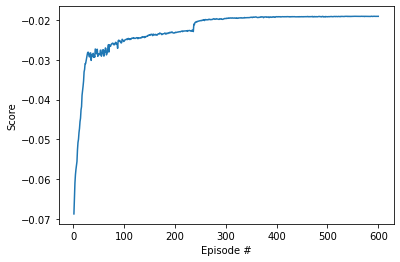

In [5]:
#Execute the cross entrophy method with default Values
#scores = cem()


#To don't ask the GPU as much reduce the pop_size, it's the amount of elemts try
scores = cem_no_net()
# 
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [3]:
# load the weights from file
# Not working know


#state = env.reset()
env = env_pybullet_kin_gen3()
env.update_parameters_to_modify(["mass","max_vel","kp","ki","damping","force_x_one","Ixx","Iyy","Izz"])
env.robot.visual_inspection = False
env.modified_parameters_df = env.create_df_from_Excel("./Parameters_train_tcp_euc.xlsx")


t.sleep(0.02)
action = env.action_modified()
action = np.array(action)
print(action)
reward = env.step_tcp_euclidian(action)

print("reward")
print(reward)
    

hola
../Simulation_Pybullet/models/urdf/JACO3_URDF_V11.urdf
Robot launched
hola
(7, 12)
(7, 17)
mass okey
max_vel okey
kp okey
ki okey
damping okey
force_x_one okey
Ixx okey
Iyy okey
Izz okey
[ 2.06489245e+00  1.59166037e+00  1.19803224e+00  1.08238260e+00
  6.44286236e-01  5.16225681e-01  6.03324395e-01  2.82580018e+01
  2.68311180e+01  1.68605077e+01  3.62852176e+01  4.36955773e+01
  3.47002498e+01  2.93739811e+01  1.57191791e-01  1.25629208e-01
  1.06933720e-01  1.33719614e-01  7.19670037e-02  1.41444918e-01
  1.44569054e-01 -8.08552287e-04  1.35491751e-03  4.04356767e-02
  4.97994406e-03  5.51046304e-02 -1.74616464e-02  3.24535887e-03
  1.44083891e-01  5.68110360e-02  9.08078322e-02  9.39380536e-02
  9.39265071e-02  1.27799834e-01  1.46565326e-01  1.39452388e+00
  9.52817454e-01  1.07631863e+00  1.32207477e+00  1.02725394e+00
  1.10520521e+00  9.75927218e-01  4.05771520e-03  8.54336267e-03
  9.48366506e-03  2.43254227e-03  2.45509549e-03  2.64648233e-03
  6.08471344e-04  5.65523015

In [4]:
#Convert to excel
a = env.df_avg.to_numpy()
print(a[:,5])
env.df_avg.to_excel("./Train_parameters_result_tcp_euc.xlsx")

[ 1.13733012e-09  1.27363815e-06 -7.80763972e-06 -5.68839240e-06
 -5.53079748e-06 -6.59984965e-06 -6.20296267e-06 -6.49144530e-06
 -7.11071392e-06 -7.91910363e-06 -8.87707712e-06 -1.00050968e-05
 -1.13788300e-05 -1.31521814e-05 -1.56287198e-05 -1.78943197e-05
 -2.29362607e-05 -3.37585354e-05 -6.46212627e-05  1.91503053e-07
 -3.14152633e+00 -3.14156125e+00 -3.14157246e+00 -3.14157796e+00
 -3.14158121e+00 -3.14158332e+00 -3.14158442e+00 -3.14158515e+00
 -3.14158576e+00 -3.14158630e+00 -3.14158677e+00 -3.14158719e+00
 -3.14158757e+00 -3.14158791e+00 -3.14158823e+00 -3.14158851e+00
 -3.14158878e+00 -3.14158902e+00 -3.14158925e+00 -3.14158947e+00
 -3.14158967e+00 -3.14158986e+00 -3.14159005e+00 -3.14159022e+00
 -3.14159039e+00 -3.14159055e+00 -3.14159070e+00 -3.14159085e+00
 -3.14159099e+00 -3.14159113e+00 -3.14159125e+00 -3.14159142e+00
 -3.14159156e+00 -3.14159168e+00 -3.14159180e+00 -3.14159192e+00
 -3.14159203e+00 -3.14159215e+00 -3.14159227e+00 -3.14159238e+00
 -3.14159249e+00 -3.14159

In [ ]:
env.original_parameters_df